In [1]:
import numpy as np
import pandas as pd
import os
import librosa
import sounddevice as sd
import torch
import torch.nn.functional as F
from matplotlib import pyplot as plt
from torch import nn
from sklearn.model_selection import train_test_split
from tqdm import tqdm

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Training on',DEVICE)

Training on cpu


In [2]:
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
# Open data frame w metadata and filenames
all_data = pd.read_csv('all_data.csv')

# Create column in DF that encodes disease state
all_data['diagnosis_flag'] = all_data['patient_diagnosis'].map(
    {'Healthy': 0,
     'COPD': 1,
     'Pneumonia': 2, 
     'Asthma': 3,
     'URTI': 4, 
     'Heart Failure': 5,
     'Bronchiectasis': 6,
     'Bronchiolitis': 7,
     'Lung Fibrosis': 8,
     'LRTI': 9,
     'Plueral Effusion': 10
    })

# list of filenames
filenames = list(all_data['filename'])


In [ ]:
SAMPLE_RATE = 22050 # Standard val - resampling to this
MAX_LENGTH = 80000 # Because most are 80,000 length
FRAME_SIZE = 2048
HOP_LENGTH = 256 # Lower val = higher res
N_MELS = 256
MIN_VAL = 0  # To normalize
MAX_VAL = 1

# Replace with your local path to all_audio_data
AUDIO_DIR_PATH = '/Users/namratah/Downloads/breathing_sound_generation/all_audio_data'

In [ ]:
# File to audio signal
def load_audio(file_path, sample_rate=SAMPLE_RATE):
    signal, sr = librosa.load(file_path, sr=None)
    signal_resampled = librosa.resample(signal, orig_sr=sr, target_sr=sample_rate)
    return signal_resampled

# Most of the audio signals are 80000 samples long
# Trim if >, pad if <
def apply_padding(array):
    if len(array) < MAX_LENGTH: 
        num_missing_items = MAX_LENGTH - len(array)
        padded_array = np.pad(array, (num_missing_items // 2, num_missing_items // 2), mode='constant')
        return padded_array
    elif len(array) > MAX_LENGTH:
        center = len(array) // 2
        start = max(0, center - MAX_LENGTH // 2)
        end = min(len(array), start + MAX_LENGTH)
        trimmed_array = array[start:end] 
        return trimmed_array
    return array
 
 # Mel spectrogram in db scale
def extract_mel_spectrogram(signal, sample_rate=SAMPLE_RATE, frame_size=FRAME_SIZE, hop_length=HOP_LENGTH, n_mels=N_MELS):
    mel_spectrogram = librosa.feature.melspectrogram(
        y=signal, sr=sample_rate, n_fft=frame_size, hop_length=hop_length, n_mels=n_mels)
    mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
    return mel_spectrogram

# Normalize
def min_max_normalize(array):
    max = array.max()
    min = array.min()
    norm_array = (array - min) / (max - min)
    return norm_array, min, max

# Denormalize 
def denormalize(norm_array, original_min, original_max, min_val, max_val):
    array = (norm_array - min_val) / (max_val - min_val)
    array = array * (original_max - original_min) + original_min
    return array

# Convert mel spec to audio in power scale
def spec_to_audio(mel_spectrogram, sr=SAMPLE_RATE, hop_length=HOP_LENGTH):
    mel_spectrogram = librosa.db_to_power(mel_spectrogram, ref=np.max)
    audio = librosa.feature.inverse.mel_to_audio(mel_spectrogram, sr=sr, hop_length=hop_length)
    return audio

# Plays audio
# Find out output_device_id value for your device using print(sd.query_devices())
def play_audio(audio, output_device_id=4):
    sd.play(audio, samplerate=SAMPLE_RATE, device=output_device_id)
    sd.wait()


In [ ]:
# Creates 4 arrays
# X: all spectrograms
# X_norm: all spectrograms normalized
# y: disease labels (as strings/names)
# y_encoded: encoded disease labels (0-10)
# Use X_norm and y_encoded for training
X =[]
y = []
y_encoded = []
X_norm = []
X_min_max = []
for idx, row in all_data.iterrows():
    filename = row['filename']
    diagnosis = row['patient_diagnosis']
    diagnosis_encoded = row['diagnosis_flag']
    file_path = os.path.join(AUDIO_DIR_PATH, filename)
    signal = load_audio(file_path)
    padded_signal = apply_padding(signal)
    mel_spec = extract_mel_spectrogram(padded_signal)
    norm_mel_spec, original_min, original_max = min_max_normalize(mel_spec)

    X.append(mel_spec)
    X_norm.append(norm_mel_spec)
    y.append(diagnosis)
    y_encoded.append(diagnosis_encoded)
    X_min_max.append([original_min, original_max])


In [ ]:
# Convert to numpy arrays, add more dimensions (not sure of purpose of this, I think to make it correct dimesions for NN layers)
# Perform train/test split (80/20)
X_arr = np.array(X_norm)
X_arr = X_arr[..., np.newaxis] 
X_arr = np.transpose(X_arr, (0, 3, 1, 2))
y_arr = np.array(y_encoded)
X_train, X_test, y_train, y_test =  train_test_split(X_arr, y_arr, test_size=0.2)

In [ ]:
# More variables
batch_size = 64
learning_rate = 0.0005 
hidden_size = 256 # Size of hidden layers
num_epochs = 10**6
input_size = 256 * 313 # Make sure this matches actual size
labels_length = 12 # 11 labels total, not sure why we have to add 1 here, they did this in the og code

In [287]:
# Convert to tensors
# Create data loaders
x_train_tensor = torch.tensor(X_train)
y_train_tensor = torch.tensor(y_train)

train_dataset = torch.utils.data.TensorDataset(x_train_tensor, y_train_tensor)
train_loader1 = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

x_test_tensor = torch.tensor(X_test)
y_test_tensor = torch.tensor(y_test)

test_dataset = torch.utils.data.TensorDataset(x_test_tensor, y_test_tensor)
test_loader1 = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

train_dataset = train_loader1
val_dataset = test_loader1

print(y_train_tensor.shape, x_train_tensor.shape, y_test_tensor.shape, x_test_tensor.shape)

torch.Size([820]) torch.Size([820, 1, 256, 313]) torch.Size([205]) torch.Size([205, 1, 256, 313])


In [288]:
def one_hot(x, max_x):
    return torch.eye(max_x + 1)[x]

def plot_gallery(images, h, w, n_row=3, n_col=6):
    plt.figure(figsize=(2 * n_col, 2 * n_row))
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.axis("off")
        plt.imshow(images[i].reshape(h, w), cmap = "plasma")
    plt.show()

def vae_loss_fn(x, recon_x, mu, logvar):
    reconstruction_loss = F.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return reconstruction_loss + KLD

def evaluate(losses, autoencoder, dataloader, flatten=True):
    model = lambda x, y: autoencoder(x, y)[0]    
    loss_sum = []
    inp, out = [],[]
    loss_fn = nn.MSELoss()
    for inputs, labels in dataloader:
        inputs = inputs.to(DEVICE)
        labels = one_hot(labels, 11).to(DEVICE)

        if flatten:
            inputs = inputs.view(inputs.size(0), input_size)

        outputs = model(inputs, labels)
        loss = loss_fn(inputs, outputs)            
        loss_sum.append(loss)
        inp = inputs
        out = outputs

    with torch.set_grad_enabled(False):
        plot_gallery([inp[0].detach().cpu(),out[0].detach().cpu()],256,313,1,2)    

    losses.append((sum(loss_sum)/len(loss_sum)).item())
    

In [289]:
class CVAE(nn.Module):
    def __init__(self, input_size, hidden_size=256):
        super(CVAE, self).__init__()
        input_size_with_label = input_size + labels_length
        hidden_size += labels_length
        
        self.fc1 = nn.Linear(input_size_with_label, 512)
        self.fc21 = nn.Linear(512, hidden_size)
        self.fc22 = nn.Linear(512, hidden_size)
        
        self.relu = nn.ReLU()
        
        self.fc3 = nn.Linear(hidden_size, 512)
        self.fc4 = nn.Linear(512, input_size)
    
    def encode(self, x, labels):
        x = x.view(-1, input_size)
        x = torch.cat((x, labels), 1)
        x = self.relu(self.fc1(x))
        return self.fc21(x), self.fc22(x)
        
    def decode(self, z):
        z = self.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(z))
        
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 *logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)
        
    def forward(self,x, labels):
        mu, logvar = self.encode(x, labels)
        z = self.reparameterize(mu, logvar)
        x = self.decode(z)
        return x, mu, logvar

def train_cvae(net, dataloader, test_dataloader, flatten=True, epochs=num_epochs):
    validation_losses = []
    optim = torch.optim.Adam(net.parameters())

    log_template = "\nEpoch {ep:03d} val_loss {v_loss:0.4f}"
    with tqdm(desc="epoch", total=epochs) as pbar_outer:  
        for i in range(epochs):
            for batch, labels in dataloader:
                batch = batch.to(DEVICE)
                labels = one_hot(labels,11).to(DEVICE)

                if flatten:
                    batch = batch.view(batch.size(0), input_size)

                optim.zero_grad()
                x,mu,logvar = net(batch, labels)
                loss = vae_loss_fn(batch, x[:, :input_size], mu, logvar)
                loss.backward()
                optim.step()
            evaluate(validation_losses, net, test_dataloader, flatten=True)
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=i+1, v_loss=validation_losses[i]))
    plt.show()
    return validation_losses

In [290]:
cvae = CVAE(input_size).to(DEVICE)

epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

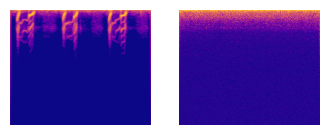

epoch:   0%|          | 1/1000 [00:12<3:24:21, 12.27s/it]


Epoch 001 val_loss 0.0299


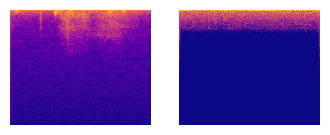

epoch:   0%|          | 2/1000 [00:22<3:02:43, 10.99s/it]


Epoch 002 val_loss 0.0290


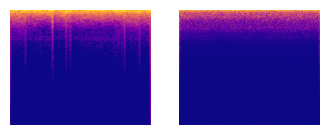

epoch:   0%|          | 3/1000 [00:34<3:07:51, 11.31s/it]


Epoch 003 val_loss 0.0183


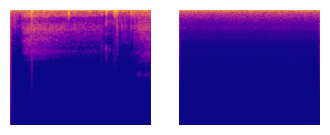

epoch:   0%|          | 4/1000 [00:46<3:14:44, 11.73s/it]


Epoch 004 val_loss 0.0173


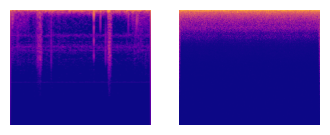

epoch:   0%|          | 5/1000 [00:59<3:20:29, 12.09s/it]


Epoch 005 val_loss 0.0239


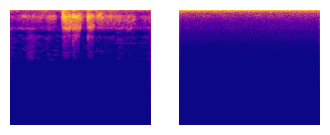

epoch:   1%|          | 6/1000 [01:12<3:25:53, 12.43s/it]


Epoch 006 val_loss 0.0225


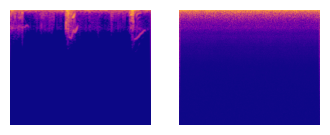

epoch:   1%|          | 7/1000 [01:25<3:30:20, 12.71s/it]


Epoch 007 val_loss 0.0101


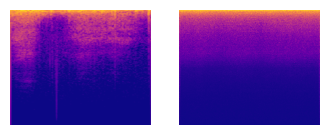

epoch:   1%|          | 8/1000 [01:39<3:36:03, 13.07s/it]


Epoch 008 val_loss 0.0097


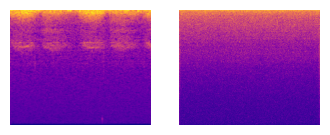

epoch:   1%|          | 9/1000 [01:53<3:40:09, 13.33s/it]


Epoch 009 val_loss 0.0095


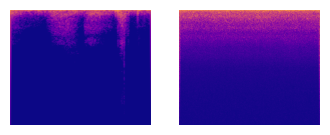

epoch:   1%|          | 10/1000 [02:07<3:45:45, 13.68s/it]


Epoch 010 val_loss 0.0102


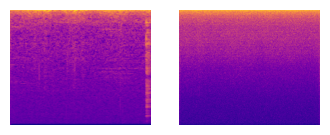

epoch:   1%|          | 11/1000 [02:21<3:48:18, 13.85s/it]


Epoch 011 val_loss 0.0079


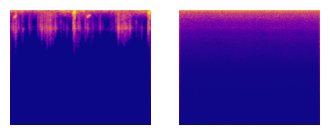

epoch:   1%|          | 12/1000 [02:36<3:50:18, 13.99s/it]


Epoch 012 val_loss 0.0112


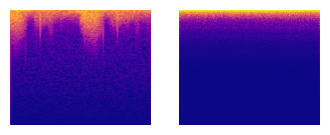

epoch:   1%|▏         | 13/1000 [02:50<3:51:35, 14.08s/it]


Epoch 013 val_loss 0.0237


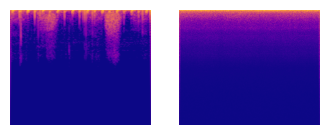

epoch:   1%|▏         | 14/1000 [03:05<3:56:31, 14.39s/it]


Epoch 014 val_loss 0.0104


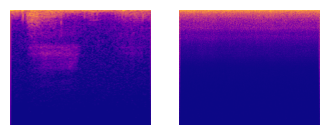

epoch:   2%|▏         | 15/1000 [03:20<3:56:56, 14.43s/it]


Epoch 015 val_loss 0.0160


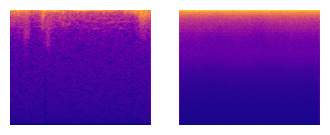

epoch:   2%|▏         | 16/1000 [03:34<3:58:02, 14.51s/it]


Epoch 016 val_loss 0.0117


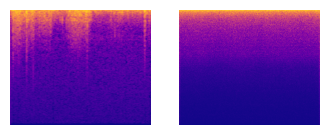

epoch:   2%|▏         | 17/1000 [03:49<3:57:32, 14.50s/it]


Epoch 017 val_loss 0.0105


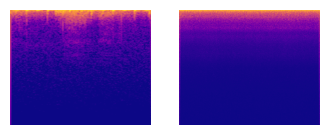

epoch:   2%|▏         | 18/1000 [04:03<3:57:10, 14.49s/it]


Epoch 018 val_loss 0.0093


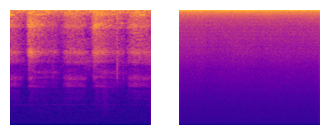

epoch:   2%|▏         | 19/1000 [04:18<3:55:46, 14.42s/it]


Epoch 019 val_loss 0.0069


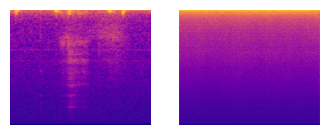

epoch:   2%|▏         | 20/1000 [04:32<3:55:42, 14.43s/it]


Epoch 020 val_loss 0.0071


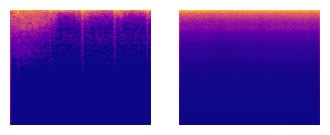

epoch:   2%|▏         | 21/1000 [04:47<3:56:25, 14.49s/it]


Epoch 021 val_loss 0.0115


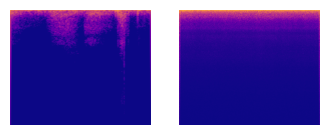

epoch:   2%|▏         | 22/1000 [05:02<3:58:18, 14.62s/it]


Epoch 022 val_loss 0.0219


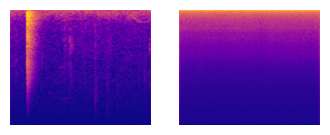

epoch:   2%|▏         | 23/1000 [05:16<3:56:29, 14.52s/it]


Epoch 023 val_loss 0.0074


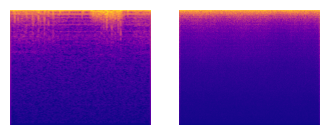

epoch:   2%|▏         | 24/1000 [05:30<3:54:18, 14.40s/it]


Epoch 024 val_loss 0.0125


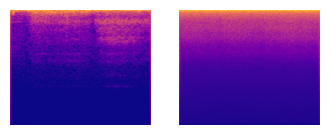

epoch:   2%|▎         | 25/1000 [05:48<4:12:51, 15.56s/it]


Epoch 025 val_loss 0.0110


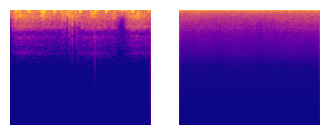

epoch:   3%|▎         | 26/1000 [06:01<3:59:34, 14.76s/it]


Epoch 026 val_loss 0.0105


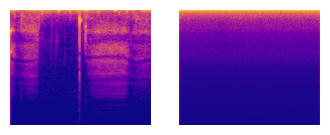

epoch:   3%|▎         | 27/1000 [06:13<3:44:32, 13.85s/it]


Epoch 027 val_loss 0.0114


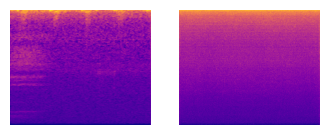

epoch:   3%|▎         | 28/1000 [06:24<3:32:55, 13.14s/it]


Epoch 028 val_loss 0.0072


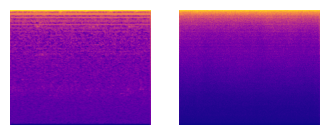

epoch:   3%|▎         | 29/1000 [06:36<3:23:50, 12.60s/it]


Epoch 029 val_loss 0.0100


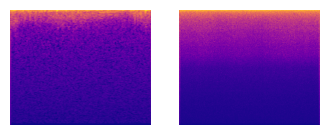

epoch:   3%|▎         | 30/1000 [06:47<3:17:29, 12.22s/it]


Epoch 030 val_loss 0.0084


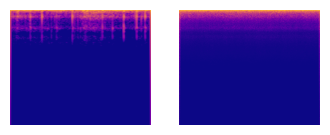

epoch:   3%|▎         | 31/1000 [06:58<3:12:32, 11.92s/it]


Epoch 031 val_loss 0.0069


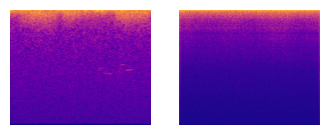

epoch:   3%|▎         | 32/1000 [07:14<3:30:29, 13.05s/it]


Epoch 032 val_loss 0.0139


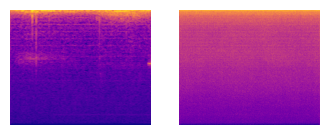

epoch:   3%|▎         | 33/1000 [07:30<3:42:36, 13.81s/it]


Epoch 033 val_loss 0.0114


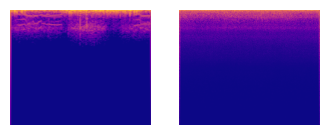

epoch:   3%|▎         | 34/1000 [07:42<3:36:39, 13.46s/it]


Epoch 034 val_loss 0.0093


epoch:   3%|▎         | 34/1000 [07:46<3:40:46, 13.71s/it]


KeyboardInterrupt: 

In [291]:
history = train_cvae(cvae, train_dataset, val_dataset)

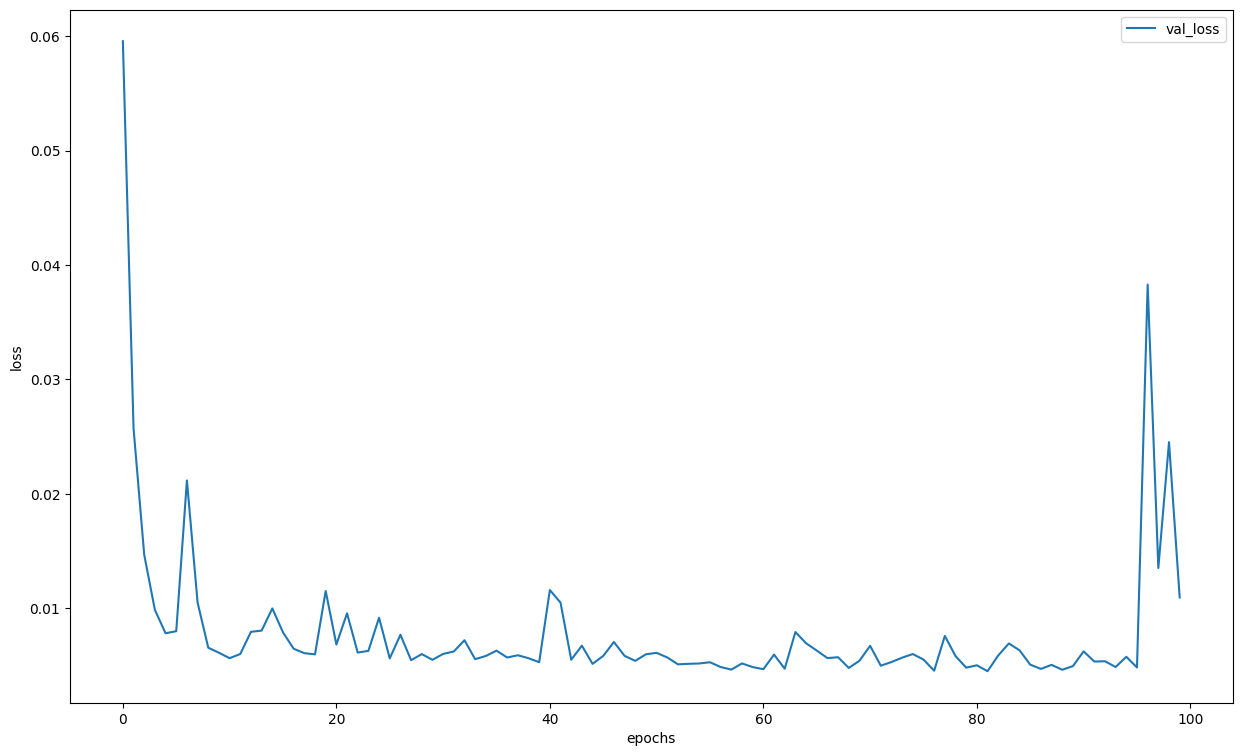

In [ ]:
val_loss = history
plt.figure(figsize=(15, 9))
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()